# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [7]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [6]:
# Import the Necessary Packages

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import time
from datetime import datetime

from collections import deque, namedtuple, OrderedDict 

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Neural Network
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_layers):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        "*** YOUR CODE HERE ***"
        # fully connected layers
        self.fc1 = nn.Linear(state_size, hidden_layers[0])
        self.fc2 = nn.Linear(hidden_layers[0], hidden_layers[1])
        self.fc3 = nn.Linear(hidden_layers[1], hidden_layers[2])

        self.output = nn.Linear(hidden_layers[2], action_size)     

    def forward(self, state):
        """Build a network that maps state -> action values."""
        # relu activation
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        x = self.output(x)
        return x

In [8]:
class duelingQNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_layers):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(duelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        "*** YOUR CODE HERE ***"
        # fully connected layers
        
        self.fc1 = nn.Linear(state_size, hidden_layers[0])
        self.fc2 = nn.Linear(hidden_layers[0], hidden_layers[1])
        self.fc3 = nn.Linear(hidden_layers[1], hidden_layers[2])
        
        ##duelling NN        
        self.fc4 = nn.Linear(hidden_layers[2], hidden_layers[3])
        self.value = nn.Linear(hidden_layers[3], 1)
        self.adv = nn.Linear(hidden_layers[3], action_size)
        

    def forward(self, state):
        """Build a network that maps state -> action values."""
        # relu activation
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        val = F.relu(self.fc4(x))
        val = self.value(val)
        
        adv = F.relu(self.fc4(x))
        adv = self.adv(adv)
        x = val + adv
        return x

In [12]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-4               # learning rate 
UPDATE_EVERY = 3        # how often to update the network

DoubleDQN = True        # Use Double DQN
DuelingDQN = True       # Use Dueling DQN
Exp_replay_DQN = True   # Use priotized experience replay

MIN_P = 0.001            # small e for prioritized exp replay
ALPHA_ = 0.57             # how much prioritization is used (0 - no prioritization, 1 - full prioritization)
BETA_START = 0.0001       # importance sampling weight - degree for use (0 - no correction, 1 - full correction)
BETA_DELTA = 0.0004       # importance sampling weight 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        if DuelingDQN:
            #print('Dueling NN')
            self.qnetwork_local = duelingQNetwork(state_size, action_size, seed, [256, 128, 64, 16]).to(device)
            self.qnetwork_target = duelingQNetwork(state_size, action_size, seed, [256, 128, 64, 16]).to(device)
        else:
            #print('Normal NN')
            self.qnetwork_local = QNetwork(state_size, action_size, seed, [256, 64, 16]).to(device)
            self.qnetwork_target = QNetwork(state_size, action_size, seed, [256, 64, 16]).to(device)
                       
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        if Exp_replay_DQN:
            self.memory = Prio_ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed, MIN_P, ALPHA_, BETA_START, BETA_DELTA)
        else:
            self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local.forward(state) #action_values = self.qnetwork_local(state) ??.forward(state)??
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        if Exp_replay_DQN:
            states, actions, rewards, next_states, dones, tupel_probs, prio_probs_idx, max_prob = experiences
        else:
            states, actions, rewards, next_states, dones = experiences

        ## TODO: compute and minimize the loss
        "*** YOUR CODE HERE ***"
        self.qnetwork_local.train()      

        # Use Double DQN
        if DoubleDQN:
            if random.random() > 0.0:
                action_max = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
            else:
                action_max = self.qnetwork_target(next_states).detach().max(1)[1].unsqueeze(1)
            Q_target_next = self.qnetwork_target(next_states).gather(1, action_max)
        # Use normal DQN
        else:
            # Calculate Qmax of next states
            Q_target_next =  self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
 
        # Calculate Q_target for current states with reward and Qmax next states
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        # Calculate Q_expected from local model and this states
        Q_expected = self.qnetwork_local.forward(states).gather(1, actions)

        if Exp_replay_DQN:
            # calculate TD error
            TD_error = (Q_target - Q_expected)
            new_TD_deltas = torch.abs(TD_error.detach().squeeze(1)).cpu().numpy()
            # update priority for each tupel
            self.memory.update_TD_deltas(prio_probs_idx, np.abs(new_TD_deltas))
            # calculate loss function
            beta_ = self.memory.new_beta()
            TD_loss = TD_error**2
            importance_samp_weights = (len(self.memory) * tupel_probs)**(-beta_)
            # normalize weights
            
            max_weight = (len(self.memory) * max_prob)**(-beta_)
            importance_samp_weights /= max_weight
            loss = torch.mean(TD_loss * importance_samp_weights)
        else:
            # calculate loss function
            loss = F.mse_loss(Q_expected, Q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

class Prio_ReplayBuffer:
    """Fixed-size buffer to store experience tuples with prioitized exp replay."""
    def __init__(self, action_size, buffer_size, batch_size, seed, min_p=1e-5, alpha = 0.6, beta = 0.001, delta_beta = 0.0005):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            min_p(float): small constant value e to prevent tuples from starving
        """    
        self.memory = deque(maxlen=buffer_size)
        self.TD_deltas = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.min_p = min_p
        self.alpha = alpha
        self.beta = beta
        self.delta_beta = delta_beta
                
        self.experience = namedtuple("Experience", field_names=["state","action","reward","new_state","done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, int(done))
        self.memory.append(e)
        # use the max priority possible for initialization for getting a better chance for beeing selected in the next learning steps
        self.TD_deltas.append(max(self.TD_deltas) if len(self.TD_deltas) > 0 else self.min_p) 
        
        
    
    def sample(self):
        TD_deltas = np.array(self.TD_deltas)
        # create probability distribution equal to tupels priority value PI, normalize by the sum of all priority values in the replay buffer
        TD_probs = TD_deltas**self.alpha / np.sum(TD_deltas**self.alpha)
        # create a index_batch with this probabilties
        prio_probs_idx = np.random.choice(np.arange(len(self.memory)), size=self.batch_size, p=TD_probs, replace=False)
        # select all tupels with these indices
        states = torch.from_numpy(np.vstack([self.memory[k].state for k in prio_probs_idx])).float().to(device)
        actions = torch.from_numpy(np.vstack([self.memory[k].action for k in prio_probs_idx])).long().to(device)
        rewards = torch.from_numpy(np.vstack([self.memory[k].reward for k in prio_probs_idx])).float().to(device)
        new_states = torch.from_numpy(np.vstack([self.memory[k].new_state for k in prio_probs_idx])).float().to(device)
        dones = torch.from_numpy(np.vstack([self.memory[k].done for k in prio_probs_idx])).float().to(device)
        
        max_prob = np.amax(TD_probs)
        tupel_probs = torch.from_numpy(np.vstack([TD_probs[k] for k in prio_probs_idx])).float().to(device)
        #print(actions)
        #print(tupel_probs)
        return states, actions, rewards, new_states, dones, tupel_probs, prio_probs_idx, max_prob
    
    def update_TD_deltas(self,prio_probs_idx, new_TD_deltas):
        for i,k in enumerate(prio_probs_idx):
            self.TD_deltas[k] = new_TD_deltas[i] + self.min_p

    def new_beta(self):
        self.beta+=self.delta_beta
        return min(self.beta, 1)
    
    def __len__(self):
        return len(self.memory)

In [13]:
def dqn(n_episodes=2000,  max_t=10000, eps_start=0.5, eps_end=0.01, eps_decay=0.87):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    done = False
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
        #while True:
            action = agent.act(state, eps)                 #select an action
            #print("t: ", t, "\t action: ", action)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done: 
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        #if i_episode % 25 == 0:
        #    file_name = """256_64_16, n_eps_{}__mt_{}__estart_{}__eend_{}__edecay_{}__batch_{}__buffer_{}__gam_{}__tau_{}__lr_{}__update_every_{}__alpha_{}__bes_{}__bed_{}.pth""".\
        #                format( n_episodes, max_t, eps_start, eps_end,\
        #                       eps_decay, BATCH_SIZE, BUFFER_SIZE, GAMMA, TAU, LR, UPDATE_EVERY,\
        #                       ALPHA_, BETA_START, BETA_DELTA)
        #    print("\nSaving scores data to:\n{}".format(file_name))
        #    torch.save(agent.qnetwork_local.state_dict(), file_name)
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            solved_in = i_episode-100
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(solved_in, np.mean(scores_window)))
            timestamp = datetime.strftime(datetime.now(), "%Y%m%d%H%M")
            file_name = """{},2566416, solved_{}__n_eps_{}__mt_{}__estart_{}__eend_{}__edecay_{}__batch_{}__buffer_{}__gam_{}__tau_{}__lr_{}__update_{}__a_{}__bs_{}__bd_{}.pth""".\
                        format(timestamp, solved_in, n_episodes, max_t, eps_start, eps_end,\
                               eps_decay, BATCH_SIZE, BUFFER_SIZE, GAMMA, TAU, LR, UPDATE_EVERY,\
                               ALPHA_, BETA_START, BETA_DELTA)
            print("Saving scores data to:\n{}".format(file_name))
            torch.save(agent.qnetwork_local.state_dict(), file_name)
            break
    return scores

Episode 100	Average Score: 4.57
Episode 200	Average Score: 12.03
Episode 223	Average Score: 13.07
Environment solved in 123 episodes!	Average Score: 13.07
Saving scores data to:
201901202213,2566416, solved_123__n_eps_2000__mt_10000__estart_0.5__eend_0.01__edecay_0.87__batch_128__buffer_1000000__gam_0.99__tau_0.001__lr_0.0001__update_3__a_0.57__bs_0.0001__bd_0.0004.pth

Total Training time = 16.1 min


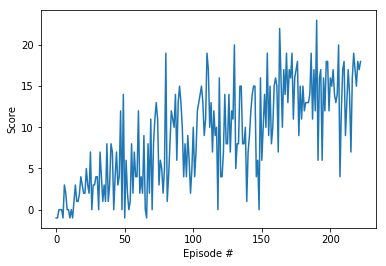

In [16]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)


agent = Agent(state_size, action_size, seed=0)
start_time = time.time() # Monitor Training Time 
scores = dqn()
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
# load the weights from file
agent = Agent(state_size, action_size, seed=0)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_banana_20190117_V01.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
eps = 0
while True:
    #action = np.random.randint(action_size)        # select an action
    action = int(agent.act(state, eps))
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))